In [2]:
import os 
import sys
# Ajouter le chemin du répertoire parent de cifar10_classification
project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)
print(project_path)

/home/mkbrad7/afs_epita/ING2/ML_reconnaissance_de_forme/Projet/classifiaction_cifar


In [3]:
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from cifar10_classification.plots import plot_confusion_matrix, plot_roc_curve
from cifar10_classification.dataset import prepare_data
from cifar10_classification.features import extract_features
from cifar10_classification.modeling.predict import predict_model
from cifar10_classification.config import LABEL_NAMES, NUM_CLASSES, DATA_DIR, MODEL_DIR, FIGURES_DIR


In [4]:
# Chemins vers les modèles sauvegardés
MODEL_PATHS = {
    'logistic_hog': MODEL_DIR + '/logistic_hog_best_model.pkl',
    'logistic_sift': MODEL_DIR + '/logistic_sift_best_model.pkl',
    'logistic_flatten': MODEL_DIR + '/logistic_flatten_best_model.pkl',
    'random_forest_flatten': MODEL_DIR + '/random_forest_flatten_best_model.pkl',
    'random_forest_sift': MODEL_DIR + '/random_forest_sift_best_model.pkl',
    'random_forest_hog': MODEL_DIR + '/random_forest_hog_best_model.pkl',
    'svm_hog': MODEL_DIR + '/svm_hog_best_model.pkl'
}

In [5]:
# Charger les données
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data()
# Fonction pour charger un modèle
def load_model(path):
    model = joblib.load(path)
    return model

# Charger les modèles
models = {name: load_model(path) for name, path in MODEL_PATHS.items()}
import pandas as pd


/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.0 when using version 1.3.0. This

In [6]:
params_list = []
for name, model in models.items():
    if hasattr(model.named_steps[model.steps[-1][0]], 'best_params_'):
        best_params = model.named_steps[model.steps[-1][0]].best_params_
    else:
        best_params = model.named_steps[model.steps[-1][0]].get_params()

    # Ajouter le nom du modèle uniquement pour la première ligne
    params_list.append({'model': name, 'param': list(best_params.keys())[0], 'value': list(best_params.values())[0]})
    
    # Ajouter les paramètres suivants sans répéter le nom du modèle
    for param, value in list(best_params.items())[1:]:
        params_list.append({'model': '', 'param': param, 'value': value})

# Stoquer ces hyperparamètres dans un dataframe
df = pd.DataFrame(params_list)
df.to_csv(MODEL_DIR + '/models_hyperparameters.csv', index=False)
df

,model,param,value
0,logistic_hog,C,0.1
1,,class_weight,None
2,,dual,False
3,,fit_intercept,True
4,,intercept_scaling,1
...,...,...,...
109,,probability,False
110,,random_state,None
111,,shrinking,True
112,,tol,0.001


In [7]:
features = {
    'flatten': extract_features(X_val, method='flatten'),
    'hog': extract_features(X_val, method='hog'),
    'sift': extract_features(X_val, method='sift')
}

/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
predictions = {}
for model_name, model in models.items():
    method = model_name.split('_')[-1]
    print(f"Predicting with {model_name}...")
    if method == 'sift':
        try:
            X_val_features = features[method]
            y_pred = model.predict(X_val_features)
        except:
            X_val_features = np.hstack((features[method], np.zeros((features[method].shape[0], 78))))
            y_pred = model.predict(X_val_features)
        # X has 50 features, but StandardScaler is expecting 128 features as input.
        # We need to add 78 zero columns to X to match the dimensionality.
    else:
        X_val_features = features[method]
        y_pred = model.predict(X_val_features)
    # y_pred = model.predict(X_val_features)
    y_score = model.predict_proba(X_val_features) if hasattr(model, "predict_proba") else model.decision_function(X_val_features)
    predictions[model_name] = (y_pred, y_score)


Predicting with logistic_hog...
Predicting with logistic_sift...
Predicting with logistic_flatten...
Predicting with random_forest_flatten...
Predicting with random_forest_sift...
Predicting with random_forest_hog...
Predicting with svm_hog...


Model: logistic_hog
Accuracy: 0.4999
Confusion matrix, without normalization
[[555  43  86  14  39   9  18  21 156  32]
 [ 32 597  13  11  25   6  36  25 100 134]
 [116  33 365  74 119 119  88  56  35  25]
 [ 37  40  91 256 110 170 143 108  21  47]
 [ 33  36  56  62 413  39 118 106  21  49]
 [ 13  23  91 117  94 443  92 104  11  27]
 [ 26  42  52  49  86  52 627  34  17  11]
 [ 17  18  63  43 121  87  26 560  20  39]
 [141 105  43  15  15   5  27  20 544 102]
 [ 28 114  18  29  43  16  18  48  87 639]]


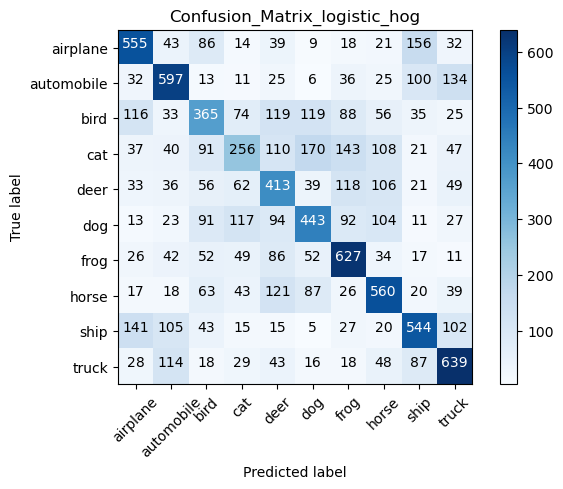

Model: logistic_sift
Accuracy: 0.0933
Confusion matrix, without normalization
[[   0    0    0    0  973    0    0    0    0    0]
 [   0    0    0    0  979    0    0    0    0    0]
 [   0    0    0    0 1030    0    0    0    0    0]
 [   0    0    0    0 1023    0    0    0    0    0]
 [   0    0    0    0  933    0    0    0    0    0]
 [   0    0    0    0 1015    0    0    0    0    0]
 [   0    0    0    0  996    0    0    0    0    0]
 [   0    0    0    0  994    0    0    0    0    0]
 [   0    0    0    0 1017    0    0    0    0    0]
 [   0    0    0    0 1040    0    0    0    0    0]]


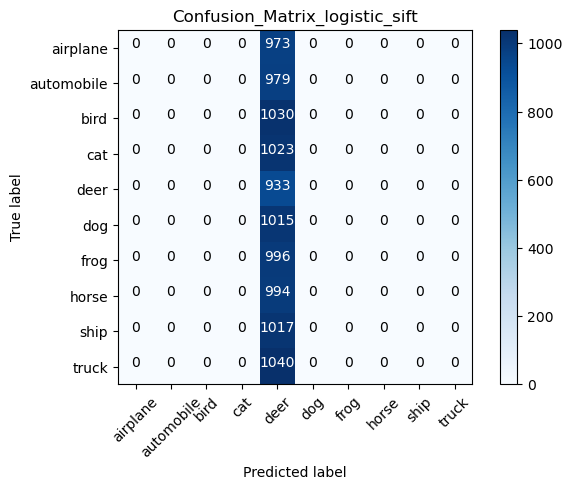

Model: logistic_flatten
Accuracy: 0.3957
Confusion matrix, without normalization
[[452  55  48  40  16  31  17  72 157  85]
 [ 53 487  29  34  22  37  50  43  58 166]
 [106  53 259  83 124  95 152  89  42  27]
 [ 42  76  98 277  65 195 133  45  41  51]
 [ 63  28 122  64 278  69 140 121  26  22]
 [ 29  50  87 180  79 332 110  78  41  29]
 [ 16  46  60 120  94  75 489  45  17  34]
 [ 50  45  59  75 133  67  53 410  32  70]
 [191  78  20  30  13  42  11  25 497 110]
 [ 82 196  17  25  12  30  48  58  96 476]]


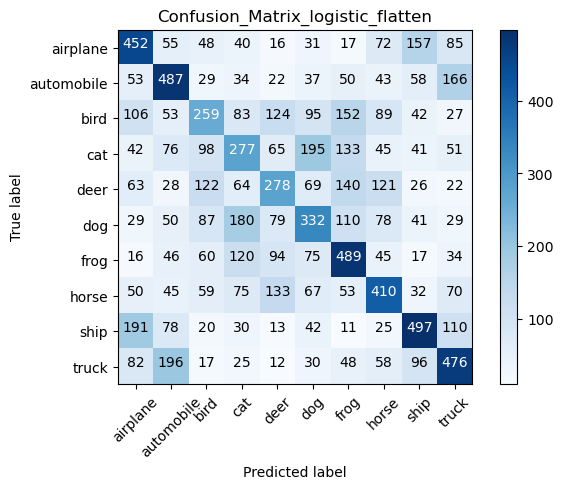

Model: random_forest_flatten
Accuracy: 0.4715
Confusion matrix, without normalization
[[537  54  30  19  28  32  21  35 146  71]
 [ 38 581  12  26  15  26  31  26  68 156]
 [ 90  57 290  73 150  75 142  63  47  43]
 [ 43  39  65 277  62 231 146  49  34  77]
 [ 69  23  89  43 405  48 118  71  36  31]
 [ 47  37  79 161  61 381 126  56  23  44]
 [ 16  21  61  60  94  69 595  24  21  35]
 [ 37  48  48  66 116  74  50 421  28 106]
 [ 98  83  11  26   7  43  15  15 656  63]
 [ 55 190   8  22   8  36  29  41  79 572]]


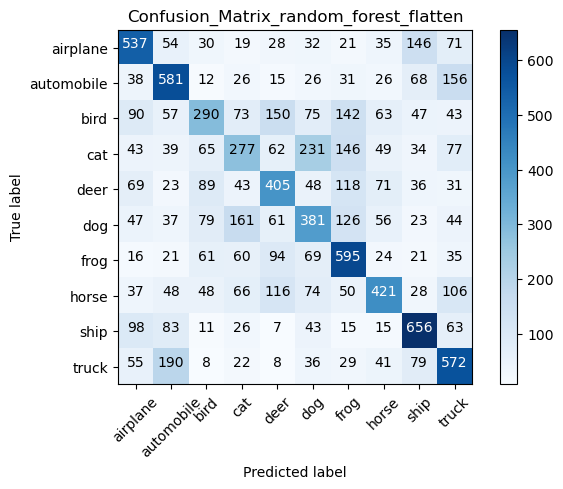

Model: random_forest_sift
Accuracy: 0.1341
Confusion matrix, without normalization
[[119 110 120  46 120  77  25  70 217  69]
 [ 49 169  61  63 123 152  58 134  72  98]
 [ 97  95 115  52 135  94  41  97 182 122]
 [ 51 102  75  49 177 127  53 175  98 116]
 [ 68  81  78  60 131  91  41 144 123 116]
 [ 45 129  69  68 134 125  52 180  76 137]
 [ 41 137  81  59 152 118  56 136  91 125]
 [ 39 150  70  54 143 139  49 165  61 124]
 [ 79  87 120  63 172  79  23  72 233  89]
 [ 20 140  39  75 141 186  65 135  60 179]]


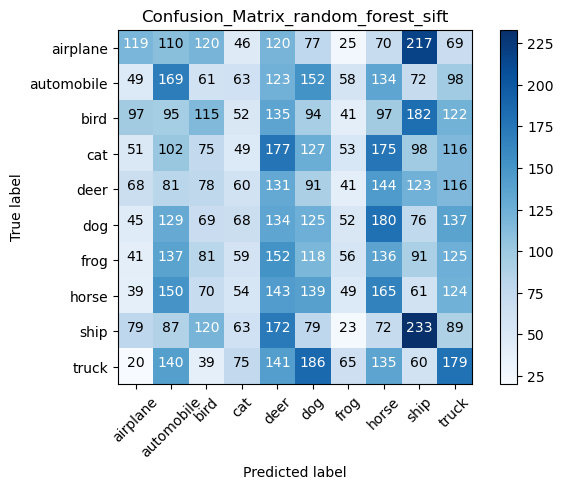

Model: random_forest_hog
Accuracy: 0.5103
Confusion matrix, without normalization
[[561  57  75  17  43  17  15  22 151  15]
 [ 33 654  10   8  17  13  36  14  97  97]
 [ 94  49 361  72  87 146 105  48  39  29]
 [ 37  38  68 245 101 246 144  78  13  53]
 [ 44  47  48  63 355  48 138 119  37  34]
 [ 10  18  82 103  80 510  89  87   5  31]
 [ 26  37  48  32  67  62 672  26  17   9]
 [ 41  30  51  34  83 121  36 534  15  49]
 [112 100  43  11  17  12  27  16 606  73]
 [ 33 125  12  15  40  23  27  60 100 605]]


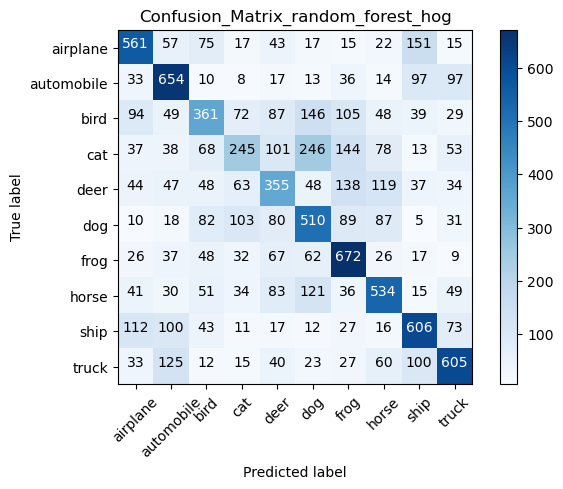

Model: svm_hog
Accuracy: 0.6252
Confusion matrix, without normalization
[[702  29  44  19  31   7  10  11  96  24]
 [ 28 752  10  14  16   3   9  10  63  74]
 [ 95  17 537  88 106  81  48  24  24  10]
 [ 46  23  89 423  84 179  86  56  15  22]
 [ 31  16  79  82 523  39  47  78  18  20]
 [ 18  10  99 176  61 520  42  68   6  15]
 [ 28  20  54  68  52  51 692  11  16   4]
 [ 23   9  45  57  83  63  19 667   4  24]
 [ 95  60  31  23  16   6   8  14 708  56]
 [ 25  92  14  38  28  23   9  30  53 728]]


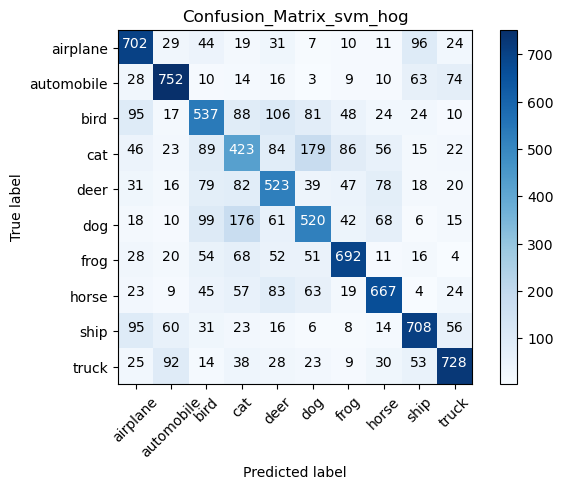

In [9]:
# Visualiser les matrices de confusion et les courbes ROC pour chaque modèle
for model_name, (y_pred, y_score) in predictions.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {np.mean(y_pred == y_val)}")
    cm = confusion_matrix(y_val, y_pred)
    plot_confusion_matrix(cm, classes=LABEL_NAMES, title=f'Confusion_Matrix_{model_name}')
    #plot_roc_curve(y_test, y_score, n_classes=NUM_CLASSES)

Model: logistic_hog
Accuracy: 0.4999


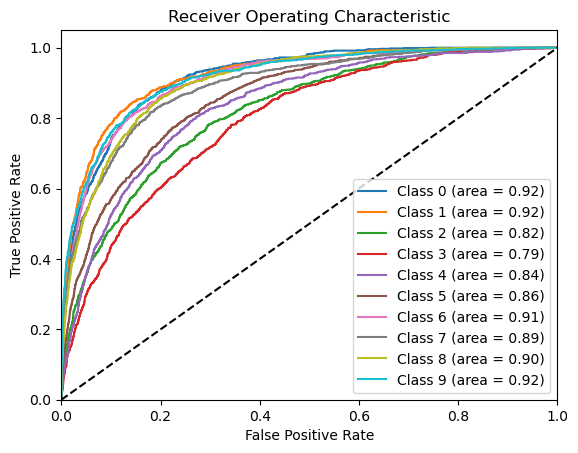

Model: logistic_sift
Accuracy: 0.0933


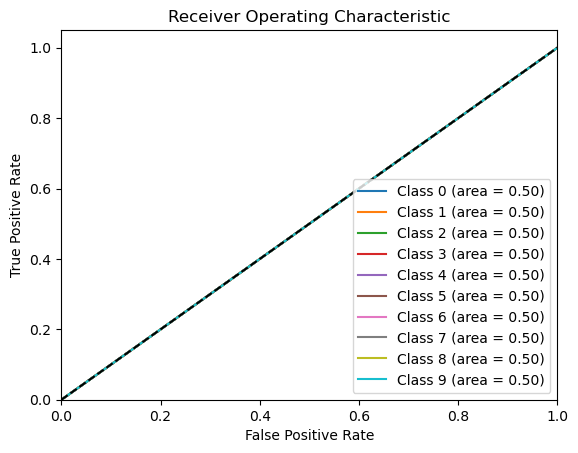

Model: logistic_flatten
Accuracy: 0.3957


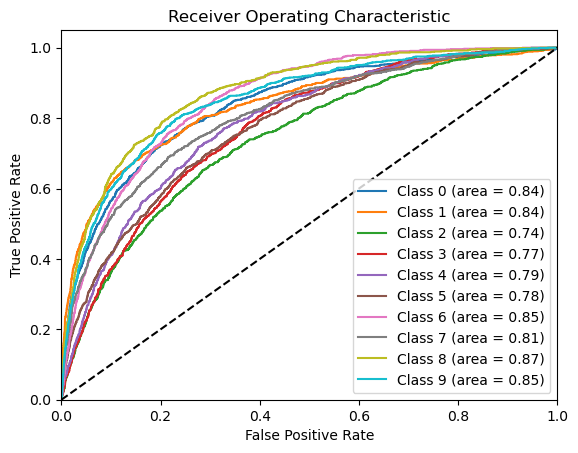

Model: random_forest_flatten
Accuracy: 0.4715


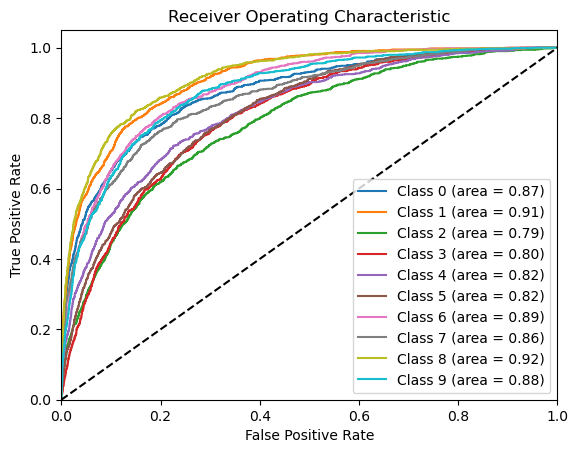

Model: random_forest_sift
Accuracy: 0.1341


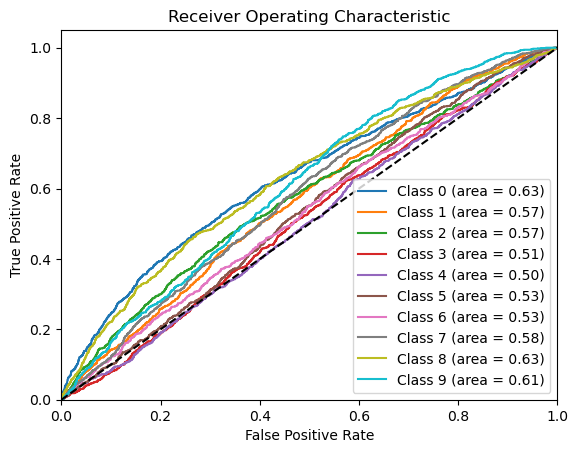

Model: random_forest_hog
Accuracy: 0.5103


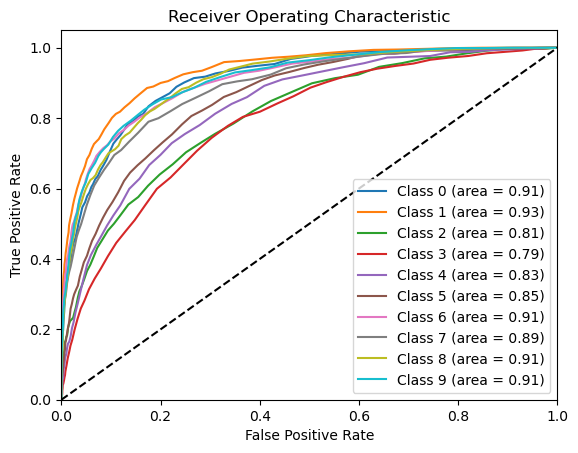

Model: svm_hog
Accuracy: 0.6252


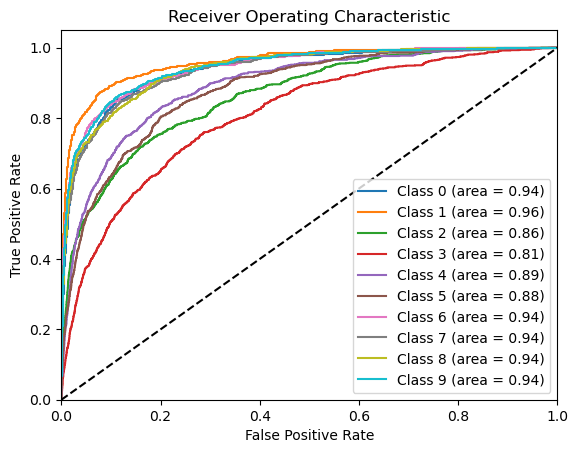

In [10]:
# Visualiser les matrices de confusion et les courbes ROC pour chaque modèle
for model_name, (y_pred, y_score) in predictions.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {np.mean(y_pred == y_val)}")
    plot_roc_curve(y_val, y_score, n_classes=NUM_CLASSES, title=f'ROC_{model_name}')

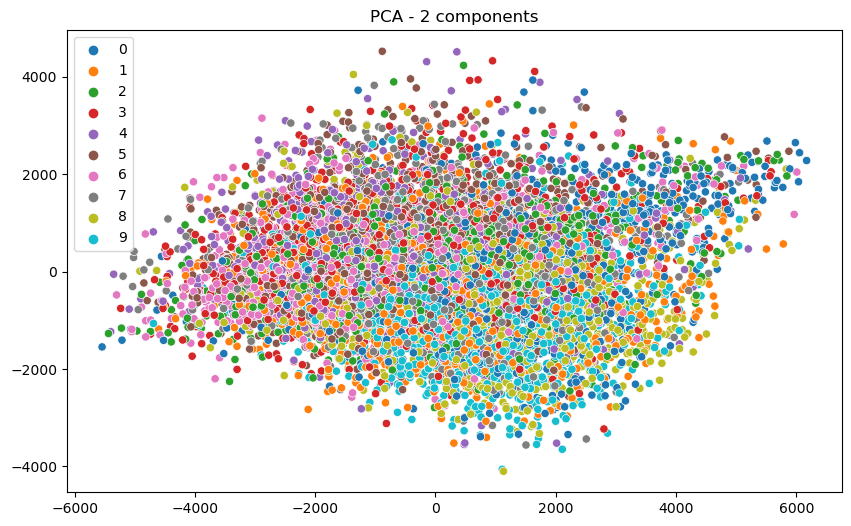

In [11]:
# visualization de l'espace latent
from sklearn.decomposition import PCA

X_val_flatten = extract_features(X_val, method='flatten')
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_flatten)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_val_pca[:, 0], y=X_val_pca[:, 1], hue=y_val, palette='tab10')
plt.title('PCA - 2 components')
plt.show()

ON voit si on optient les meme résultat avec l'ensemble de test


In [12]:
features_test = {
    'flatten': extract_features(X_test, method='flatten'),
    'hog': extract_features(X_test, method='hog'),
    'sift': extract_features(X_test, method='sift')
}

/home/mkbrad7/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:

predictions_test = {}
for model_name, model in models.items():
    method = model_name.split('_')[-1]
    print(f"Predicting with {model_name}...")
    if method == 'sift':
        try:
            X_test_features = features_test[method]
            y_pred = model.predict(X_test_features)
        except:
            X_test_features = np.hstack((features_test[method], np.zeros((features_test[method].shape[0], 78))))
            y_pred = model.predict(X_test_features)
        # X has 50 features, but StandardScaler is expecting 128 features as input.
        # We need to add 78 zero columns to X to match the dimensionality.
    else:
        X_test_features = features_test[method]
        y_pred = model.predict(X_test_features)
    # y_pred = model.predict(X_val_features)
    y_score = model.predict_proba(X_test_features) if hasattr(model, "predict_proba") else model.decision_function(X_test_features)
    predictions_test[model_name] = (y_pred, y_score)

Predicting with logistic_hog...
Predicting with logistic_sift...
Predicting with logistic_flatten...
Predicting with random_forest_flatten...
Predicting with random_forest_sift...
Predicting with random_forest_hog...
Predicting with svm_hog...


Model: logistic_hog
Accuracy: 0.5042
Confusion matrix, without normalization
[[589  40  93   8  42   7  26  17 155  23]
 [ 41 604  20  16  29   8  58  21  90 113]
 [ 82  25 383  67  93 124 107  56  44  19]
 [ 46  51  79 274 107 159 131  77  28  48]
 [ 38  31  61  70 431  72 123  94  34  46]
 [ 10  18  82 139  87 422 107  92  15  28]
 [ 20  46  50  54  88  61 633  20  18  10]
 [ 23  23  63  51 105  87  31 551  17  49]
 [162 113  30  17  16   7  20  16 525  94]
 [ 36 102  18  22  32  26  12  43  79 630]]


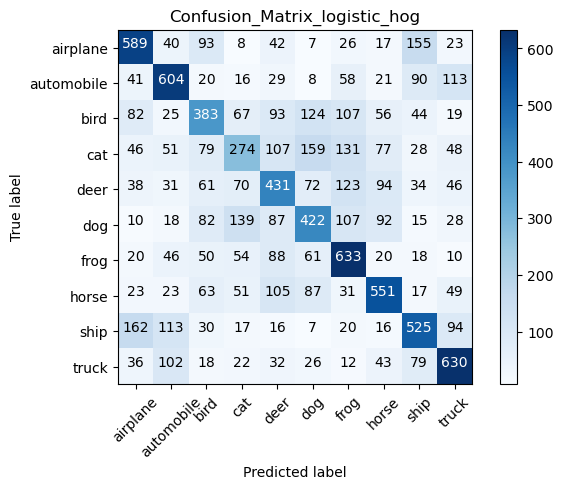

Model: logistic_sift
Accuracy: 0.1
Confusion matrix, without normalization
[[   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]]


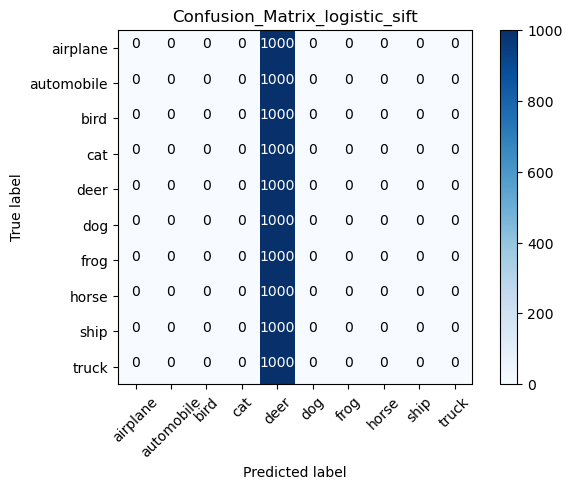

Model: logistic_flatten
Accuracy: 0.3957
Confusion matrix, without normalization
[[472  47  55  29  21  30  24  55 196  71]
 [ 63 500  25  39  24  43  38  40  77 151]
 [101  47 241  87 131  81 162  79  50  21]
 [ 45  68 100 260  56 183 134  49  38  67]
 [ 51  32 149  70 282  75 166 126  27  22]
 [ 43  54  92 157  71 341  88  83  48  23]
 [ 13  37  82 126 104  77 481  32  15  33]
 [ 43  43  58  55 109  78  60 422  44  88]
 [175  78  23  27  11  47  10  19 501 109]
 [ 70 183  21  28  16  24  44  56 101 457]]


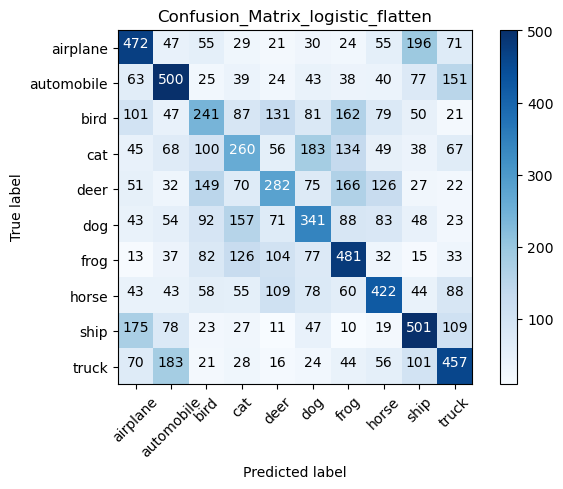

Model: random_forest_flatten
Accuracy: 0.4739
Confusion matrix, without normalization
[[570  48  37  24  36  15  30  27 153  60]
 [ 38 602  19  32  14  20  21  30  75 149]
 [108  43 297  74 155  65 137  48  47  26]
 [ 56  56  62 243  58 191 150  65  33  86]
 [ 61  18 113  61 420  33 150  84  29  31]
 [ 22  32  64 146  62 396 115  85  38  40]
 [ 13  20  77  44 112  52 601  25  23  33]
 [ 42  42  31  58  92  85  56 452  38 104]
 [101  79  10  19  16  37  19  12 631  76]
 [ 38 182  11  35  12  27  38  35  95 527]]


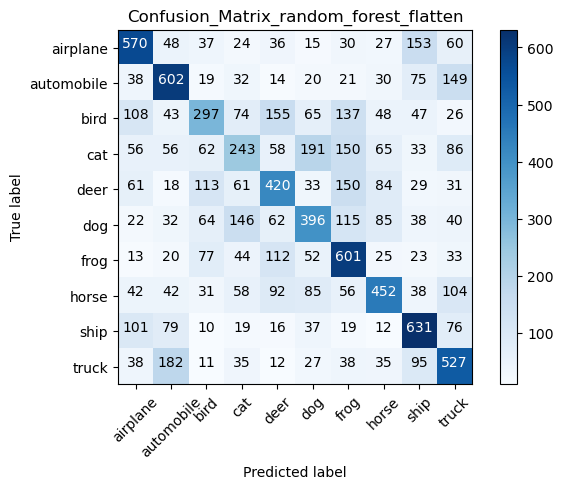

Model: random_forest_sift
Accuracy: 0.1378
Confusion matrix, without normalization
[[143  70 171  59 108  53  42  96 183  75]
 [ 46 168  78  49 125 106  84 148  77 119]
 [103 106 102  81  92  73  52  98 205  88]
 [ 24 157  52  63 117  79  52 170  98 188]
 [ 44 155  71  68  99  84  30 179 128 142]
 [ 24 186  53  60  87  99  44 163  97 187]
 [ 38 148  63  83  95  97  61 182 108 125]
 [ 31 142  47  56  95  81  72 236  65 175]
 [114  93 154  43 106  60  50  58 261  61]
 [ 39 150  67  55 110  82  65 223  63 146]]


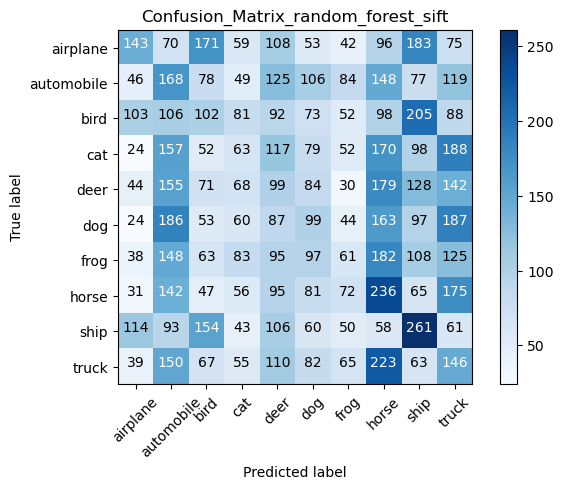

Model: random_forest_hog
Accuracy: 0.5065
Confusion matrix, without normalization
[[598  42  78  14  41  20  29  15 146  17]
 [ 31 643   8  16  16  13  67  22 103  81]
 [ 77  31 360  53 100 148 125  46  39  21]
 [ 39  44  63 249 103 210 141  72  16  63]
 [ 46  51  66  46 357  82 158 110  34  50]
 [ 10  20  73 114  82 456 101 100   9  35]
 [ 23  51  52  34  56  71 663  23  12  15]
 [ 28  28  47  43  94 119  33 534  19  55]
 [120 104  26  14  17  12  22   9 607  69]
 [ 38 125  12  28  31  28  20  40  80 598]]


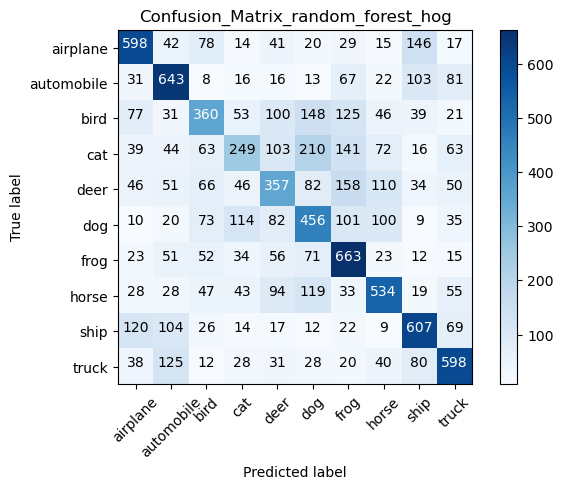

Model: svm_hog
Accuracy: 0.6292
Confusion matrix, without normalization
[[712  21  60  22  30  13  15   7 100  20]
 [ 29 782   7  15  18   6  14   5  52  72]
 [ 82  12 527  75  94  79  63  29  28  11]
 [ 50  19  96 423  85 170  77  39  13  28]
 [ 38  17  92  86 565  57  57  57   9  22]
 [ 16   6  88 175  69 502  52  67  11  14]
 [ 23  19  45  64  60  43 707  12  17  10]
 [ 22   9  56  67  71  61  12 669  11  22]
 [112  70  25  18  10  10   9  12 684  50]
 [ 26  82  12  40  19  14   7  21  58 721]]


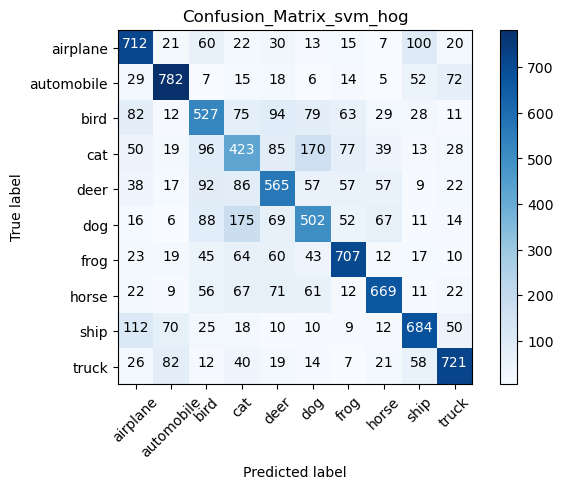

In [14]:
# Visualiser les matrices de confusion et les courbes ROC pour chaque modèle
for model_name, (y_pred, y_score) in predictions_test.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {np.mean(y_pred == y_test)}")
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=LABEL_NAMES, title=f'Confusion_Matrix_{model_name}')
    #plot_roc_curve(y_test, y_score, n_classes=NUM_CLASSES)

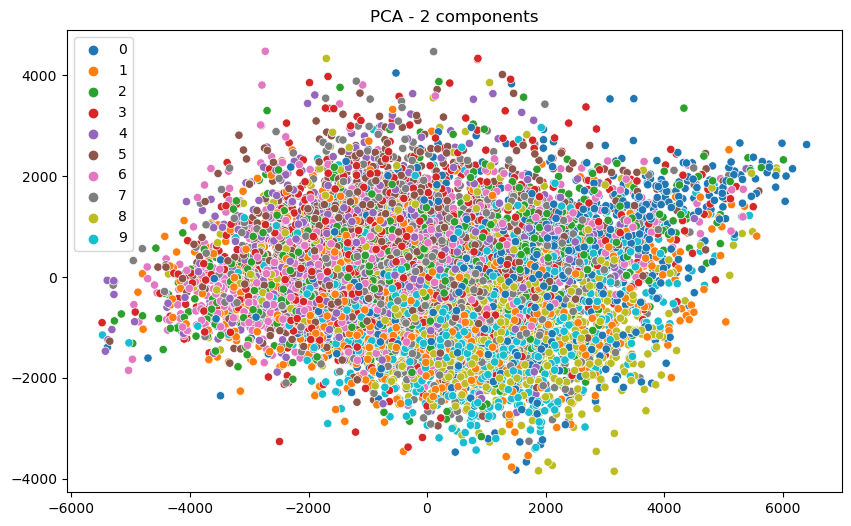

In [16]:
# visualization de l'espace latent
from sklearn.decomposition import PCA

X_test_flatten = extract_features(X_test, method='flatten')
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_flatten)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette='tab10')
plt.title('PCA - 2 components')
plt.savefig(os.path.join(FIGURES_DIR, 'pca.png'))
plt.show()